In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Read File
file_path = 'cleaned.csv'
hmda = pd.read_csv(file_path)

In [3]:
hmda.dtypes

as_of_year                          int64
action_taken                        int64
loan_type                           int64
loan_purpose                        int64
loan_amount_000s                  float64
msamd                             float64
state_code                        float64
county_code                       float64
applicant_ethnicity                 int64
co_applicant_ethnicity              int64
applicant_race_1                    int64
co_applicant_race_1                 int64
applicant_sex                       int64
co_applicant_sex                    int64
applicant_income_000s             float64
purchaser_type                      int64
rate_spread                       float64
hoepa_status                        int64
population                        float64
minority_population               float64
hud_median_family_income          float64
tract_to_msamd_income             float64
number_of_owner_occupied_units    float64
number_of_1_to_4_family_units     

In [4]:
# Set up data for machine learning
# Create function that creates stratified samples of a dataset
def stratified_sample(df, col, sample_size):
    """Creates a new dataframe that has the same proportions of specified column as the original dataframe"""
    sample = pd.DataFrame()
    total_obs = df.shape[0]
    grouped = df.groupby(col)
    for category in list(grouped.groups.keys()):
        group = grouped.get_group(category)
        group_size = group.shape[0]
        group_sample_size = round((group_size / total_obs) * sample_size)
        if sample.shape[0] > 0:
            sample = pd.concat([sample, group.sample(n=group_sample_size, random_state=313)], ignore_index=True)
        else:
            sample = grouped.get_group(category).sample(n=group_sample_size, random_state=313)
    return sample

# Function that collects all data for a specific year
def set_year(df, year):
    """Creates a new dataframe that contains all observations for a specific year"""
    year_data = df[df['as_of_year'] == year]
    return year_data

# Function that splits data into training and test sets
def split_xy(df, y_col):
    """Splits a dataframe into X and y components. The function assumes that the last column is the y variable."""
    X = df.drop(columns=[y_col])
    y = df[y_col]
    return [X, y]

# Create sample function that only draws from specified values in a column
def value_sample(df, col, value, sample_size):
    """Creates a dataframe that has a randome sample of observations that have specified value in
    specified column. For example, if col = 'applicant_race_1' and value = 5 (which corresponds to white), 
    the sample will only have observations where the applicant is white.""" 
    sample = df[df[col] == value].sample(sample_size, random_state=313)
    return sample

# Function that create training data for white model and all race model, and test data for each race
def model_samples(df, year_sample_size, test_sample_size, remove_race=True):
    """Fucntion that creates our training and test data for our ML models. If remove_race is true, the models will be 
    blind to the races of each application."""
    # First collect equal sized samples from each year
    data_by_year = []
    for year in range(2007, 2018):
        year_dataset = set_year(df, year)
        # Create training data for white and all race models
        white_train = value_sample(year_dataset, 'applicant_race_1', 5, year_sample_size)
        all_train = stratified_sample(year_dataset, 'applicant_race_1', year_sample_size)
        if remove_race:
            white_train = white_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            all_train = all_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
        # Create test data for each race
        race_tests = []
        for race in range(1, 6):
            race_sample = value_sample(year_dataset, 'applicant_race_1', race, test_sample_size)
            if remove_race:
                race_sample = race_sample.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            race_tests.append(race_sample)
        data_by_year.append([white_train, all_train, race_tests])
    # Complied the data for each year
    year_data = data_by_year.pop(0) 
    compiled_white = year_data[0]
    compiled_all_race = year_data[1]
    compiled_race_tests = year_data[2]
    while len(data_by_year) > 0:
        year_data = data_by_year.pop(0)
        compiled_white = pd.concat([compiled_white, year_data[0]], ignore_index=True)
        compiled_all_race = pd.concat([compiled_all_race, year_data[1]], ignore_index=True)
        for i in range(0, 5):
            compiled_race_tests[i] = pd.concat([compiled_race_tests[i], year_data[2][i]], ignore_index=True)
    return [compiled_white, compiled_all_race, compiled_race_tests]

def model_testing(model, sample_data, y_col, cv=5, param_grid=None):
    """Fits white model and all race based on the specified training data. The y_col is the y variable column name.
    The sample_data parameter is the output of the model_samples function and param_grid is the hyperparameter grid
    that will be used in the GridSearchCV function. This function will return the results of the each model with given 
    parameters and the testing results from each race."""
    # Create the white model dataset
    X_white, y_white = split_xy(sample_data[0], y_col)
    # Create the all race model dataset
    X_all, y_all = split_xy(sample_data[1], y_col)

    # Set up Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)
    # Define scoring metrics
    scoring = {'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy'}

    # Initialize GridSearchCV for White Only Model
    white_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
    white_search.fit(X_white, y_white)
    # Initialize GridSearchCV for All Races Model
    all_search = GridSearchCV(model, param_grid, scoring=scoring, cv=stratified_kfold, refit='roc_auc', return_train_score=True)
    all_search.fit(X_all, y_all)

    # Extract results for each model
    white_results = pd.DataFrame(white_search.cv_results_)
    all_results = pd.DataFrame(all_search.cv_results_)
    # Add model type to results
    white_results['Model'] = 'White only'
    all_results['Model'] = 'All races'
    # Combine results
    combined_results = pd.concat([white_results, all_results])

    # Sort combined results by index then drop
    combined_results = combined_results.sort_index()

    # Select relevant columns and rename them for clarity
    relevant_columns = [f'param_{param}' for param in param_grid.keys()] + [
        'mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy', 'Model']
    combined_results = combined_results[relevant_columns]

    # Rename columns for final output
    column_mapping = {f'param_{param}': param for param in param_grid.keys()}
    column_mapping.update({
        'mean_test_roc_auc': 'ROC-AUC Score',
        'mean_test_precision': 'Precision',
        'mean_test_recall': 'Recall',
        'mean_test_accuracy': 'Accuracy'})
    combined_results.rename(columns=column_mapping, inplace=True)

    # Order the columns of so that Model is first
    column_order = ['Model'] + [param for param in param_grid.keys()] + ['ROC-AUC Score', 'Precision', 'Recall', 'Accuracy']
    combined_results = combined_results[column_order]

    return combined_results

# Remove rate spread from the dataset
hmda_no_rate_spread = hmda.drop(columns=['rate_spread'])

# Adjust sample and test sizes for models and testing 
samples = model_samples(hmda_no_rate_spread, 1000, 200)

# Set up model and hyperparameter grids
logit = LogisticRegression(random_state=313)
rforest = RandomForestClassifier(random_state=313)

model_testing(rforest, samples, 'action_taken', param_grid={'max_depth': [3, 5], 'bootstrap': [True], 'max_samples':[100, 500]}, cv=5)

,Model,max_depth,bootstrap,max_samples,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,3,True,100,0.861798,1.0,0.441633,0.909091
0,All races,3,True,100,0.871956,1.0,0.447846,0.915818
1,White only,3,True,500,0.876116,1.0,0.558911,0.928182
1,All races,3,True,500,0.882720,1.0,0.571262,0.934636
2,White only,5,True,100,0.865591,1.0,0.489678,0.916909
2,All races,5,True,100,0.870669,1.0,0.492553,0.922636
3,White only,5,True,500,0.883420,1.0,0.561705,0.928636
3,All races,5,True,500,0.890711,1.0,0.579012,0.935818


In [5]:
def race_tests(model, sample_data, y_col, cv=5, param_grid=None):
    """Function that tests each race sample against the specified model. The y_col is the y variable column name."""
    race_strings = ['American Indian', 'Asian', 'Black', 'Hawaiian/Other', 'White']
    # Create the white model dataset
    X_white, y_white = split_xy(sample_data[0], y_col)
    # Create the all race model dataset
    X_all, y_all = split_xy(sample_data[1], y_col)

    # Set up Stratified K-Fold cross-validation
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)

    # Initialize GridSearchCV for White Only Model
    white_search = GridSearchCV(model, param_grid=param_grid, cv=stratified_kfold)
    white_model = white_search.fit(X_white, y_white)
    # Initialize GridSearchCV for All Races Model
    all_search = GridSearchCV(model, param_grid=param_grid, cv=stratified_kfold)
    all_race_model = all_search.fit(X_all, y_all)

    # Predict the test data for each race
    models = []
    race = []
    accuracy = []
    precision = []
    recall = []
    roc_auc = []
    confusion_mats = []
    for i in range(0, 5):
        X_test, y_test = split_xy(sample_data[2][i], y_col)
        white_preds = white_model.predict(X_test)
        white_results = classification_report(y_test, white_preds, output_dict=True)
        all_race_preds = all_race_model.predict(X_test)
        all_race_results = classification_report(y_test, all_race_preds, output_dict=True)
        # Add results to thier respective lists
        models.append('White Only')
        models.append('All Races')
        race.append(race_strings[i])
        race.append(race_strings[i])
        accuracy.append(white_results['accuracy'])
        accuracy.append(all_race_results['accuracy'])
        precision.append(white_results['1']['precision'])
        precision.append(all_race_results['1']['precision'])
        recall.append(white_results['1']['recall'])
        recall.append(all_race_results['1']['recall'])
        roc_auc.append(white_results['1']['f1-score'])
        roc_auc.append(all_race_results['1']['f1-score'])
        # Add confusion matrices values to list
        confusion_mats.append(confusion_matrix(y_test, white_preds))
        confusion_mats.append(confusion_matrix(y_test, all_race_preds))
    return pd.DataFrame({'Model': models, 'Race': race, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'ROC-AUC': roc_auc, 'Confusion Matrix': confusion_mats})

# Example usage, only put in one hyperparameter imput for each model 
race_tests(RandomForestClassifier(random_state=313), samples, 'action_taken', param_grid={'max_depth': [5], 'bootstrap': [True], 'max_samples':[500]})

,Model,Race,Accuracy,Precision,Recall,ROC-AUC,Confusion Matrix
0,White Only,American Indian,0.940909,1.0,0.500000,0.666667,"[[1940, 0], [130, 130]]"
1,All Races,American Indian,0.941364,1.0,0.503846,0.670077,"[[1940, 0], [129, 131]]"
2,White Only,Asian,0.964091,1.0,0.612745,0.759878,"[[1996, 0], [79, 125]]"
3,All Races,Asian,0.963636,1.0,0.607843,0.756098,"[[1996, 0], [80, 124]]"
4,White Only,Black,0.958182,1.0,0.666667,0.800000,"[[1924, 0], [92, 184]]"
5,All Races,Black,0.958182,1.0,0.666667,0.800000,"[[1924, 0], [92, 184]]"
6,White Only,Hawaiian/Other,0.967727,1.0,0.684444,0.812665,"[[1975, 0], [71, 154]]"
7,All Races,Hawaiian/Other,0.967727,1.0,0.684444,0.812665,"[[1975, 0], [71, 154]]"
8,White Only,White,0.932273,1.0,0.568116,0.724584,"[[1855, 0], [149, 196]]"
9,All Races,White,0.932273,1.0,0.568116,0.724584,"[[1855, 0], [149, 196]]"


In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
logit = LogisticRegression(random_state=313)

logit = Pipeline([
    ('scaler', StandardScaler()),  
    ('logit', LogisticRegression(random_state=313))
])

model_testing(logit, samples, 'action_taken', param_grid={'logit__penalty': ['l2'],
             'logit__C': [0.1, 1, 10, 100], 'logit__max_iter':[100, 500]}, cv=5)

,Model,logit__penalty,logit__C,logit__max_iter,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,l2,0.1,100,0.887164,0.996102,0.543281,0.925273
0,All races,l2,0.1,100,0.895526,0.995917,0.558136,0.932273
1,White only,l2,0.1,500,0.887164,0.996102,0.543281,0.925273
1,All races,l2,0.1,500,0.895526,0.995917,0.558136,0.932273
2,White only,l2,1,100,0.887336,0.995212,0.564496,0.928636
2,All races,l2,1,100,0.895452,0.993208,0.581994,0.935636
3,White only,l2,1,500,0.887336,0.995212,0.564496,0.928636
3,All races,l2,1,500,0.895452,0.993208,0.581994,0.935636
4,White only,l2,10,100,0.887278,0.994217,0.565055,0.928636
4,All races,l2,10,100,0.895428,0.993208,0.581994,0.935636


In [7]:
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

nb_model = GaussianNB()

results_nb = model_testing(nb_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_nb)

In [8]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30],
                  'min_samples_split': [2, 5, 10]}

rf_model = RandomForestClassifier(random_state=313)

# Example usage of model_testing function with Random Forest
model_testing(rf_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_rf)


,Model,n_estimators,max_depth,min_samples_split,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,50,10,2,0.900359,0.998013,0.561705,0.928455
0,All races,50,10,2,0.908898,1.000000,0.579012,0.935818
1,White only,100,10,2,0.903932,1.000000,0.561705,0.928636
1,All races,100,10,2,0.911045,1.000000,0.579012,0.935818
2,White only,200,10,2,0.905085,1.000000,0.561705,0.928636
2,All races,200,10,2,0.912636,1.000000,0.579012,0.935818
3,White only,50,10,5,0.902295,1.000000,0.561705,0.928636
3,All races,50,10,5,0.909319,1.000000,0.579012,0.935818
4,All races,100,10,5,0.912334,1.000000,0.579012,0.935818
4,White only,100,10,5,0.904961,1.000000,0.561705,0.928636


In [9]:
param_grid_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Initialize KNN classifier
knn_model = KNeighborsClassifier()

# Example usage of model_testing function with KNN
model_testing(knn_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_knn)

,Model,n_neighbors,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,1,0.529944,0.213683,0.211044,0.745000
0,All races,1,0.519289,0.185553,0.181880,0.753818
1,White only,2,0.544061,0.249956,0.049132,0.821364
1,All races,2,0.538512,0.212247,0.035773,0.832636
2,White only,3,0.545815,0.204665,0.105523,0.787545
2,All races,3,0.535623,0.190237,0.082882,0.806364
3,White only,4,0.552219,0.251340,0.036296,0.826909
3,All races,4,0.535934,0.178621,0.016105,0.838818
4,White only,5,0.552035,0.239603,0.064210,0.814455
4,All races,5,0.541661,0.179919,0.036375,0.827000


In [10]:
# Dropping rate_spread for now as well
X = hmda.drop(columns=['action_taken', 'rate_spread'])
y = hmda['action_taken']


In [11]:
# X = pd.get_dummies(X, drop_first=True)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
# Naive Bayes Classifier model
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

GaussianNB()

In [15]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95   4134860
           1       0.99      0.54      0.70    838472

    accuracy                           0.92   4973332
   macro avg       0.95      0.77      0.83   4973332
weighted avg       0.93      0.92      0.91   4973332

Confusion Matrix
[[4130172    4688]
 [ 386934  451538]]


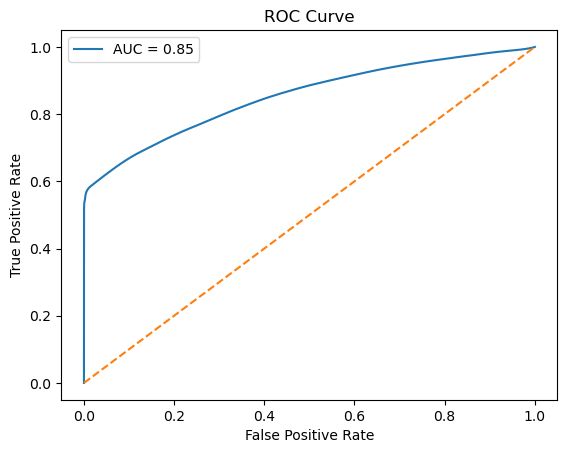

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:, 1])
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [17]:
param_grid_nb = {'var_smoothing': [1e-9, 1e-8, 1e-7]}

nb_model = GaussianNB()

results_nb = model_testing(nb_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_nb)

results_nb

,Model,var_smoothing,ROC-AUC Score,Precision,Recall,Accuracy
0,White only,0.0,0.842437,0.914271,0.527644,0.915000
0,All races,0.0,0.852484,0.924985,0.539655,0.923091
1,White only,0.0,0.818120,0.786118,0.389175,0.883364
1,All races,0.0,0.823646,0.804034,0.387008,0.892000
2,White only,0.0,0.742178,0.547855,0.210492,0.845091
2,All races,0.0,0.738486,0.506888,0.226606,0.849000


In [18]:
hmda.columns

Index(['as_of_year', 'action_taken', 'loan_type', 'loan_purpose',
       'loan_amount_000s', 'msamd', 'state_code', 'county_code',
       'applicant_ethnicity', 'co_applicant_ethnicity', 'applicant_race_1',
       'co_applicant_race_1', 'applicant_sex', 'co_applicant_sex',
       'applicant_income_000s', 'purchaser_type', 'rate_spread',
       'hoepa_status', 'population', 'minority_population',
       'hud_median_family_income', 'tract_to_msamd_income',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units'],
      dtype='object')

In [19]:
state_mapping = {
    1: 'Alabama', 2: 'Alaska', 4: 'Arizona', 5: 'Arkansas', 6: 'California', 8: 'Colorado', 
    9: 'Connecticut', 10: 'Delaware', 11: 'District of Columbia', 12: 'Florida', 13: 'Georgia', 
    15: 'Hawaii', 16: 'Idaho', 17: 'Illinois', 18: 'Indiana', 19: 'Iowa', 20: 'Kansas', 
    21: 'Kentucky', 22: 'Louisiana', 23: 'Maine', 24: 'Maryland', 25: 'Massachusetts', 
    26: 'Michigan', 27: 'Minnesota', 28: 'Mississippi', 29: 'Missouri', 30: 'Montana', 
    31: 'Nebraska', 32: 'Nevada', 33: 'New Hampshire', 34: 'New Jersey', 35: 'New Mexico', 
    36: 'New York', 37: 'North Carolina', 38: 'North Dakota', 39: 'Ohio', 40: 'Oklahoma', 
    41: 'Oregon', 42: 'Pennsylvania', 44: 'Rhode Island', 45: 'South Carolina', 46: 'South Dakota', 
    47: 'Tennessee', 48: 'Texas', 49: 'Utah', 50: 'Vermont', 51: 'Virginia', 53: 'Washington', 
    54: 'West Virginia', 55: 'Wisconsin', 56: 'Wyoming'
}

In [20]:
hmda['state_code'] = hmda['state_code'].map(state_mapping)

In [21]:
hmda['state_code']

0                  Texas
1                  Texas
2           Pennsylvania
3                Arizona
4               Michigan
                ...     
24866653      California
24866654        Virginia
24866655           Texas
24866656       Louisiana
24866657       Louisiana
Name: state_code, Length: 24866658, dtype: object

In [175]:
from sklearn.metrics import make_scorer, roc_auc_score, precision_score, recall_score

def model_sample_states(df, year_sample_size, test_sample_size, remove_race = True):

       # First collect equal sized samples from each year
    data_by_year = []
    for year in range(2007, 2018):
        year_dataset = set_year(df, year)
        # Create training data for white and all race models
        white_train = value_sample(year_dataset, 'applicant_race_1', 5, year_sample_size)
        all_train = stratified_sample(year_dataset, 'applicant_race_1', year_sample_size)
        if remove_race:
            white_train = white_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            all_train = all_train.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
    # group by state
        state_tests = []
        for state in df['state_code'].unique():
            state_sample = value_sample(year_dataset, 'state_code', state, year_sample_size)
            state_train = stratified_sample(state_sample, 'state_code', year_sample_size)
            state_tests.append(state_train)
        #group by race 
        for race in range(1,6):
            race_tests = []
            race_sample = value_sample(year_dataset, 'applicant_race_1', race, test_sample_size)
            race_sample = stratified_sample(race_sample, 'state_code', test_sample_size)
            # if remove_race:
            #     race_sample = race_sample.drop(columns=['applicant_race_1', 'co_applicant_race_1'])
            race_tests.append(race_sample)
        data_by_year.append([all_train, state_tests, race_tests])
        
    # # Complied the data for each year
    # year_data = data_by_year.pop(0) 
    # compiled_all_train = year_data[0]
    # compiled_state_tests = year_data[1]
    # compiled_race_tests = year_data[2]
    # while len(data_by_year) > 0:
    #     year_data = data_by_year.pop(0)
    #     compiled_all_train = pd.concat([compiled_all_train, year_data[0]], ignore_index=True)
    #     compiled_state = pd.concat([compiled_state_tests, year_data[1]], ignore_index=True)
    #     for i in range(0, 5):
    #         compiled_race_tests[i] = pd.concat([compiled_race_tests[i], year_data[2][i]], ignore_index=True)
    # return [compiled_all_train, compiled_state_tests, compiled_race_tests]



def model_testing_by_state(model, sample_data, y_col, cv = 5, param_grid=None):


    # for state in sample_data.unique():
    # X_train, y_train = split_xy(sample_data[0], y_col)

    
    stratified_kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=313)

    scoring = {'roc_auc': 'roc_auc', 'precision': 'precision', 'recall': 'recall', 'accuracy': 'accuracy'}
    

    search = GridSearchCV(model, param_grid, scoring ='roc_auc', cv=stratified_kfold, refit='roc_auc', return_train_score=True)
    search.fit(X_train, y_train)

    state_df = {}
    
    # Get unique states
    states_data = sample_data.unique()
    
    # Loop through each state
    for state in states_data:  
        X_train, y_train = split_xy(sample_data[0], y_col)
        
        state_df = pd.concat([x_train, y_train], axis=1)  # Concatenate x_train and y_train into one DataFrame
        
        # Store the DataFrame in the dictionary
        state_df[state] = state_df
        
    state_df = state_df.sort_index()
    results = pd.DataFrame(search.cv_results_)

    
    relevant_columns = [f'param_{param}' for param in param_grid.keys()] + [
        'roc_auc', 'precision', 'recall', 'accuracy', 'Model']
    state_df = state_df[relevant_columns]

   
    column_mapping = {f'param_{param}': param for param in param_grid.keys()}
    column_mapping.update({
        'roc_auc': 'ROC-AUC Score',
        'precision': 'Precision',
        'recall': 'Recall',
        'accuracy': 'Accuracy'})
    results.rename(columns=column_mapping, inplace=True)

    # Order the columns so that Model is first
    column_order = ['Model'] + [param for param in param_grid.keys()] + ['ROC-AUC Score', 'Precision', 'Recall', 'Accuracy']
    # results = results[column_order]

    return results


In [ ]:
# Adjust sample and test sizes for models and testing 
state_samples = model_sample_states(hmda_no_rate_spread, 200, 1000)

In [ ]:
logit = LogisticRegression(random_state=313)
rforest = RandomForestClassifier(random_state=313)

param_grid_nb = {'var_smoothing': [1e-9]}
results_nb = model_testing_by_state(nb_model, samples, y_col='action_taken', cv=5, param_grid=param_grid_nb)

In [ ]:
results_nb